In [1]:
# Importing used libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, roc_curve, precision_recall_curve, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Training model

In [3]:
# Importing datasets to pandas dataframe
train = pd.read_csv('puzzle_train_dataset.csv')

Data types:
-----------
ids                    object
default                object
score_1                object
score_2                object
score_3               float64
score_4               float64
score_5               float64
score_6               float64
risk_rate             float64
amount_borrowed       float64
borrowed_in_months    float64
credit_limit          float64
reason                 object
income                float64
sign                   object
gender                 object
facebook_profile       object
last_payment           object
end_last_loan          object
state                  object
zip                    object
channel                object
job_name               object
real_state             object
ok_since              float64
n_bankruptcies        float64
n_defaulted_loans     float64
n_accounts            float64
n_issues              float64
dtype: object

Sum of null values in each feature:
-----------------------------------
ids                

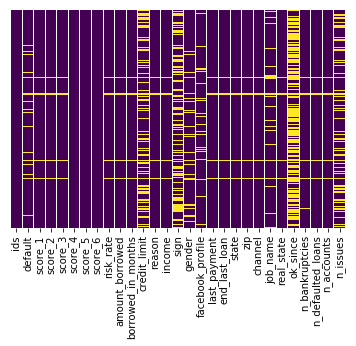

In [4]:
# Check both the datatypes and if there is missing values for the train dataset
print(f"\033[1m\033[94mData types:\n{11 * '-'}")
print(f"\033[30m{train.dtypes}\n")
print(f"\033[1m\033[94mSum of null values in each feature:\n{35 * '-'}")
print(f"\033[30m{train.isnull().sum()}")
train.head()
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [5]:
# Removing missing default values
train.dropna(subset=['default'], inplace=True)

In [6]:
# n_issues, ok_since, sign and credit_limit too many info missing
# facebook_profile, zip and channel don't think it's that useful
train.drop(columns=['facebook_profile','ok_since','credit_limit','sign','n_issues','zip','channel'], inplace=True, axis=1)

Positive examples = 9510
Negative examples = 50456
Proportion of positive to negative examples = 18.85%


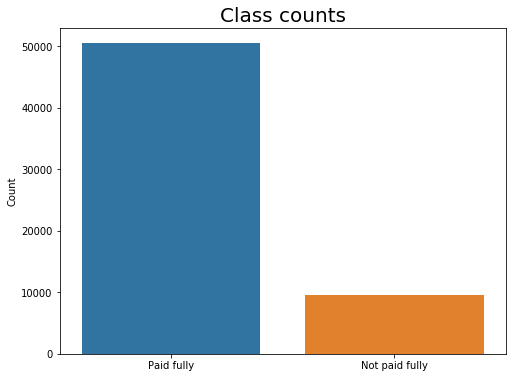

In [7]:
# Get number of positve and negative examples
pos = train[train["default"] == 1].shape[0]
neg = train[train["default"] == 0].shape[0]
print(f"Positive examples = {pos}")
print(f"Negative examples = {neg}")
print(f"Proportion of positive to negative examples = {(pos / neg) * 100:.2f}%")
plt.figure(figsize=(8, 6))
sns.countplot(train["default"])
plt.xticks((0, 1), ["Paid fully", "Not paid fully"])
plt.xlabel("")
plt.ylabel("Count")
plt.title("Class counts", y=1, fontdict={"fontsize": 20});

In [8]:
# Payment not paid when last payment is missing
print(train[train['last_payment'].isna()]['default'].value_counts())

# Payment fully paid when end last loan missing
print(train[train['end_last_loan'].isna()]['default'].value_counts())

True    77
Name: default, dtype: int64
False    3
Name: default, dtype: int64


In [9]:
# Removing missing last_payment and end_last_loan values
# By the analysis before, if end_last_loan is nan the default is false
# if last_payment is nan the default is true
# Priority of end_last_loan over last_payment
train.dropna(subset=['last_payment','end_last_loan'], inplace=True)

In [10]:
# Changing object types to categorical numbers
def cat_code_str(df,columns):
    for col in columns:
        df[col] = df[col].astype('category')
        df[col+'_cat'] = df[col].cat.codes
    df.drop(columns=columns, inplace=True, axis=1)
    
cat_code_str(train,['score_1','score_2','gender','state','job_name','real_state','reason'])

In [11]:
# Filling n_bankruptcies and n_default_loans missing values
train['n_bankruptcies'].fillna(value=train.n_bankruptcies.mean(), inplace=True)
train['n_defaulted_loans'].fillna(value=train.n_defaulted_loans.mean(), inplace=True)

In [12]:
def treat_datetime(df,columns):
    for col in columns:
        df[col] = df[col].astype('datetime64')
        min_col, max_col = df[col].min(), df[col].max()
        df[col+'_asdt64'] = (df[col] - min_col)/(max_col - min_col)
    df.drop(columns=columns, inplace=True, axis=1)
    
treat_datetime(train,['last_payment','end_last_loan'])

In [13]:
X = train.drop(columns=['ids','default'], axis=1)
y = train['default'].astype(bool)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)
train.drop('ids', axis=1, inplace=True)

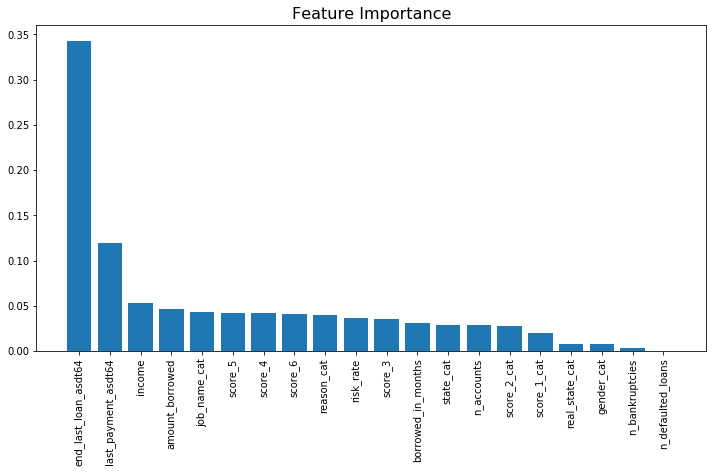

In [14]:
rfc = RandomForestClassifier(n_estimators=100, max_features=0.25, criterion='entropy', class_weight='balanced')
rfc.fit(RobustScaler().fit_transform(X_train), y_train)

# Plot features importance
importances = rfc.feature_importances_
indices = np.argsort(rfc.feature_importances_)[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(1, 21), importances[indices], align="center")
plt.xticks(range(1, 21),
           train.columns[train.columns != 'default'][indices],
           rotation=90)
plt.title("Feature Importance", {"fontsize": 16});

In [15]:
# Drop features from score_3 to not overfit
X_train.drop(columns=['score_2_cat','score_1_cat','gender_cat','real_state_cat',
                     'n_bankruptcies','n_defaulted_loans'], axis=1, inplace=True)
X_test.drop(columns=['score_2_cat','score_1_cat','gender_cat','real_state_cat',
                     'n_bankruptcies','n_defaulted_loans'], axis=1, inplace=True)

c:\users\felip\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [16]:
# Standardize the data
std = RobustScaler()
std.fit(X_train)
X_std_train = std.transform(X_train)
X_std_test = std.transform(X_test)

## Searching Random Forest best estimators. Running may take a while*

In [17]:
param_grid = {
    'n_estimators': [100,200,300],
    'max_depth': [5,6,7,8,9,10],
    'max_features': [0.25,0.5,0.75]
}

In [18]:
grid = GridSearchCV(RandomForestClassifier(), param_grid, verbose=3)

In [19]:
# Searching for the bests estimators
grid.fit(X_std_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] max_depth=5, max_features=0.25, n_estimators=100 ................
[CV]  max_depth=5, max_features=0.25, n_estimators=100, score=0.8486537257357546, total=   3.2s
[CV] max_depth=5, max_features=0.25, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV]  max_depth=5, max_features=0.25, n_estimators=100, score=0.8597282234329012, total=   3.3s
[CV] max_depth=5, max_features=0.25, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.1s remaining:    0.0s


[CV]  max_depth=5, max_features=0.25, n_estimators=100, score=0.8555325944016532, total=   3.4s
[CV] max_depth=5, max_features=0.25, n_estimators=200 ................
[CV]  max_depth=5, max_features=0.25, n_estimators=200, score=0.8546649968691297, total=   6.3s
[CV] max_depth=5, max_features=0.25, n_estimators=200 ................
[CV]  max_depth=5, max_features=0.25, n_estimators=200, score=0.8562840503475484, total=   6.2s
[CV] max_depth=5, max_features=0.25, n_estimators=200 ................
[CV]  max_depth=5, max_features=0.25, n_estimators=200, score=0.8576617195816896, total=   6.1s
[CV] max_depth=5, max_features=0.25, n_estimators=300 ................
[CV]  max_depth=5, max_features=0.25, n_estimators=300, score=0.8566061365059486, total=   9.1s
[CV] max_depth=5, max_features=0.25, n_estimators=300 ................
[CV]  max_depth=5, max_features=0.25, n_estimators=300, score=0.8565971569916714, total=   9.7s
[CV] max_depth=5, max_features=0.25, n_estimators=300 ...............

[CV]  max_depth=6, max_features=0.75, n_estimators=300, score=0.9113908197131944, total=  30.3s
[CV] max_depth=6, max_features=0.75, n_estimators=300 ................
[CV]  max_depth=6, max_features=0.75, n_estimators=300, score=0.9110150917402468, total=  30.5s
[CV] max_depth=7, max_features=0.25, n_estimators=100 ................
[CV]  max_depth=7, max_features=0.25, n_estimators=100, score=0.8948027551659361, total=   4.0s
[CV] max_depth=7, max_features=0.25, n_estimators=100 ................
[CV]  max_depth=7, max_features=0.25, n_estimators=100, score=0.8857786962239339, total=   3.9s
[CV] max_depth=7, max_features=0.25, n_estimators=100 ................
[CV]  max_depth=7, max_features=0.25, n_estimators=100, score=0.8874068507733734, total=   3.9s
[CV] max_depth=7, max_features=0.25, n_estimators=200 ................
[CV]  max_depth=7, max_features=0.25, n_estimators=200, score=0.8878522229179712, total=   7.9s
[CV] max_depth=7, max_features=0.25, n_estimators=200 ...............

[CV]  max_depth=8, max_features=0.75, n_estimators=200, score=0.9118346900438322, total=  25.5s
[CV] max_depth=8, max_features=0.75, n_estimators=200 ................
[CV]  max_depth=8, max_features=0.75, n_estimators=200, score=0.9143340221679505, total=  25.4s
[CV] max_depth=8, max_features=0.75, n_estimators=200 ................
[CV]  max_depth=8, max_features=0.75, n_estimators=200, score=0.9145845074832488, total=  26.7s
[CV] max_depth=8, max_features=0.75, n_estimators=300 ................
[CV]  max_depth=8, max_features=0.75, n_estimators=300, score=0.9119599248591108, total=  39.1s
[CV] max_depth=8, max_features=0.75, n_estimators=300 ................
[CV]  max_depth=8, max_features=0.75, n_estimators=300, score=0.914083536852652, total=  38.1s
[CV] max_depth=8, max_features=0.75, n_estimators=300 ................
[CV]  max_depth=8, max_features=0.75, n_estimators=300, score=0.9146471288120734, total=  42.1s
[CV] max_depth=9, max_features=0.25, n_estimators=100 ................

[CV]  max_depth=10, max_features=0.5, n_estimators=300, score=0.9146471288120734, total=  30.5s
[CV] max_depth=10, max_features=0.75, n_estimators=100 ...............
[CV]  max_depth=10, max_features=0.75, n_estimators=100, score=0.9127113337507827, total=  14.5s
[CV] max_depth=10, max_features=0.75, n_estimators=100 ...............
[CV]  max_depth=10, max_features=0.75, n_estimators=100, score=0.9149602354561964, total=  14.2s
[CV] max_depth=10, max_features=0.75, n_estimators=100 ...............
[CV]  max_depth=10, max_features=0.75, n_estimators=100, score=0.91596217671739, total=  14.3s
[CV] max_depth=10, max_features=0.75, n_estimators=200 ...............
[CV]  max_depth=10, max_features=0.75, n_estimators=200, score=0.9120225422667502, total=  28.8s
[CV] max_depth=10, max_features=0.75, n_estimators=200 ...............
[CV]  max_depth=10, max_features=0.75, n_estimators=200, score=0.9160874193750391, total=  28.4s
[CV] max_depth=10, max_features=0.75, n_estimators=200 ...........

[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 46.2min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 200, 300], 'max_depth': [5, 6, 7, 8, 9, 10], 'max_features': [0.25, 0.5, 0.75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [65]:
"""RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features=0.75, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)"""
print(grid.best_estimator_)
print('score = ', grid.best_score_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features=0.75, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
score =  0.9149411371795942


In [33]:
pred = grid.predict(X_std_test)

<Figure size 1152x576 with 0 Axes>

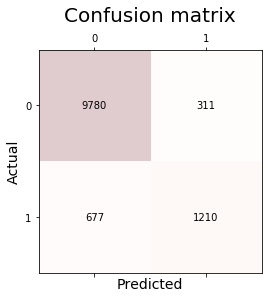

In [34]:
conf_mat = confusion_matrix(y_test, pred)

plt.figure(figsize=(16, 8))
plt.matshow(conf_mat, cmap=plt.cm.Reds, alpha=0.2)
for i in range(2):
  for j in range(2):
    plt.text(x=j, y=i, s=conf_mat[i, j], ha="center", va="center")
plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14});

## Model evaluation

In [66]:
best_rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features=0.75, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

best_rfc.fit(X_std_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features=0.75, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

<Figure size 1152x576 with 0 Axes>

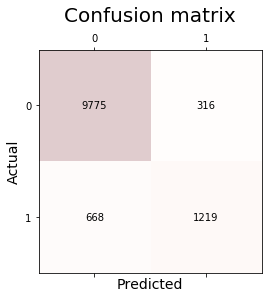

In [67]:
best_rfc_pred = best_rfc.predict(X_std_test)
conf_mat = confusion_matrix(y_test, best_rfc_pred)

plt.figure(figsize=(16, 8))
plt.matshow(conf_mat, cmap=plt.cm.Reds, alpha=0.2)
for i in range(2):
  for j in range(2):
    plt.text(x=j, y=i, s=conf_mat[i, j], ha="center", va="center")
plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14});

In [86]:
from sklearn.metrics import classification_report
print(classification_report(y_test, best_rfc_pred))

              precision    recall  f1-score   support

       False       0.94      0.97      0.95     10091
        True       0.79      0.65      0.71      1887

   micro avg       0.92      0.92      0.92     11978
   macro avg       0.87      0.81      0.83     11978
weighted avg       0.91      0.92      0.91     11978



# Predicting the test dataset

In [46]:
test = pd.read_csv('puzzle_test_dataset.csv')

In [47]:
test.drop(columns=['facebook_profile','ok_since','credit_limit','sign','n_issues','zip','channel'], inplace=True, axis=1)

In [48]:
test.dropna(subset=['last_payment','end_last_loan'], inplace=True)

In [49]:
cat_code_str(test,['score_1','score_2','gender','state','job_name','real_state','reason'])

In [50]:
test['n_bankruptcies'].fillna(value=train.n_bankruptcies.mean(), inplace=True)
test['n_defaulted_loans'].fillna(value=train.n_defaulted_loans.mean(), inplace=True)

In [51]:
treat_datetime(test,['last_payment','end_last_loan'])

In [52]:
test.drop(columns=['score_2_cat','score_1_cat','gender_cat','real_state_cat',
                     'n_bankruptcies','n_defaulted_loans'], axis=1, inplace=True)

In [54]:
std_test = std.transform(test.drop('ids', axis=1))

In [55]:
test_pred = best_rfc.predict(std_test)

In [57]:
submission = {'ids': test['ids'],
              'predictions': test_pred}
submission = pd.DataFrame(submission)

In [58]:
default_missing = pd.read_csv('puzzle_test_dataset.csv')

na_end_last_loan = {'ids': default_missing[default_missing['end_last_loan'].isna()]['ids'],
                    'predictions': False}
default_missing.dropna(subset=['end_last_loan'], inplace=True)
na_last_payment = {'ids': default_missing[default_missing['last_payment'].isna()]['ids'],
                   'predictions': True}

na_end_last_loan = pd.DataFrame(na_end_last_loan)
na_last_payment = pd.DataFrame(na_last_payment)

In [59]:
submission = pd.concat([submission,na_end_last_loan,na_last_payment])

In [61]:
submission.to_csv('predictions.csv', index=False)